In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn; seaborn.set()
from sklearn.metrics import mean_squared_error
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# get data
# hsx
df = pd.read_csv('CafeF.HSX.Upto29.03.2019.csv')
# vn30 ky 1 2019
frames = [df[df['<Ticker>']== 'CMG']]
data = pd.concat(frames)

In [3]:
data.set_index('<DTYYYYMMDD>', inplace = True)
print(len(data))
data.drop(['<Ticker>'], inplace=True, axis = 1)
data.index = pd.to_datetime(data.index.astype(str), format = '%Y%m%d')
data = data.sort_index()
data.ffill()
print(len(data))

2275
2275


In [4]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

In [5]:
def train_test_split(df, test_size=5):
    split_row = len(df) - 5
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [6]:
target_col = '<Close>'
train, test = train_test_split(data, test_size=0.1)
# line_plot(train[target_col], test[target_col], 'training', 'test', title='CMG')

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_for_stationary(input_data):   
     #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(input_data)
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dfoutput)
    print(dftest[1])
    if dftest[1] <= 0.05:
        print("Data is stationary")      
    else:
        print("Data is non - stationary")
    print(dftest[0] < list(dftest[4].items())[0][1])

In [8]:
ts = train[target_col]
print(len(ts))
test_for_stationary(ts)

2270
Results of Dickey-Fuller Test:
0.9021858623735384
Data is non - stationary
False


In [9]:
# ts_logtransformed = np.log(ts)
# test_for_stationary(ts_logtransformed)

In [10]:
ts_diff = (ts - ts.shift(1))
# ts_log_diff = np.sign(ts_diff)*np.log(np.abs(ts_diff))
ts_diff.dropna(inplace=True)
print(len(ts_diff))
test_for_stationary(ts_diff)

2269
Results of Dickey-Fuller Test:
5.438965064876928e-16
Data is stationary
True


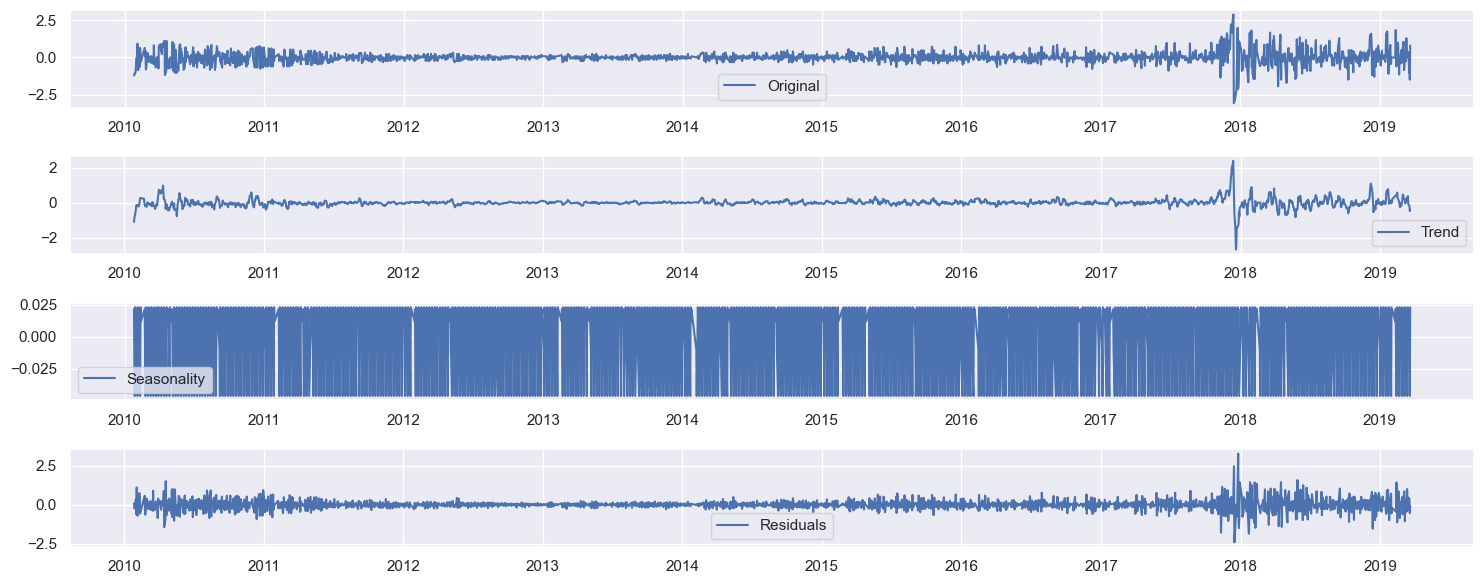

In [14]:
decomposition = seasonal_decompose(ts_diff, period=5)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [15]:
decomposed_TS = residual
decomposed_TS.dropna(inplace=True)
test_for_stationary(decomposed_TS)

Results of Dickey-Fuller Test:
2.3273296804099047e-30
Data is stationary
True


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


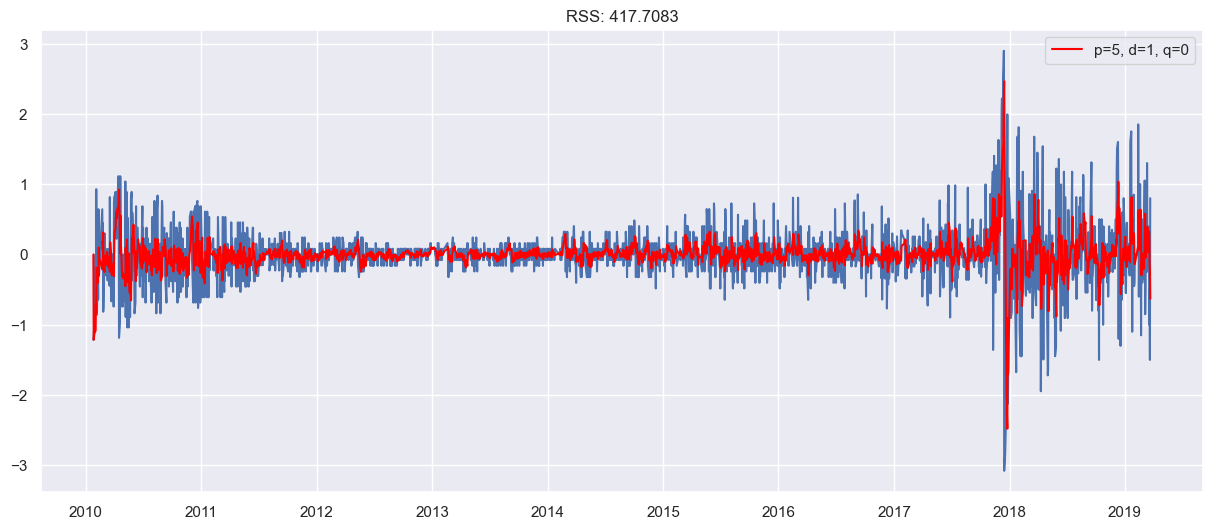

In [23]:
model = ARIMA(ts_diff, order=(5, 1, 0))
results_ARIMA = model.fit()
plt.plot(ts_diff)
plt.plot(results_ARIMA.fittedvalues, color='red', label='p=5, d=1, q=0')
RSS = results_ARIMA.fittedvalues - ts_diff
RSS.dropna(inplace=True)
plt.title('RSS: %.4f' % sum(RSS**2))
plt.legend(loc='best')


In [24]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

<DTYYYYMMDD>
2010-01-25    0.000000
2010-01-26   -1.213400
2010-01-27   -1.170885
2010-01-28   -1.127523
2010-01-29   -1.115934
dtype: float64


In [25]:
#model summary
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                <Close>   No. Observations:                 2269
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1295.872
Date:                Sat, 18 Feb 2023   AIC                           2603.743
Time:                        18:20:28   BIC                           2638.103
Sample:                             0   HQIC                          2616.280
                               - 2269                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6470      0.008    -84.045      0.000      -0.662      -0.632
ar.L2         -0.5115      0.010    -53.694      0.000      -0.530      -0.493
ar.L3         -0.3934      0.011    -35.033      0.0

count    2269.000000
mean        0.000672
std         0.429155
min        -5.541308
25%        -0.154414
50%        -0.003668
75%         0.145092
max         4.469589
dtype: float64


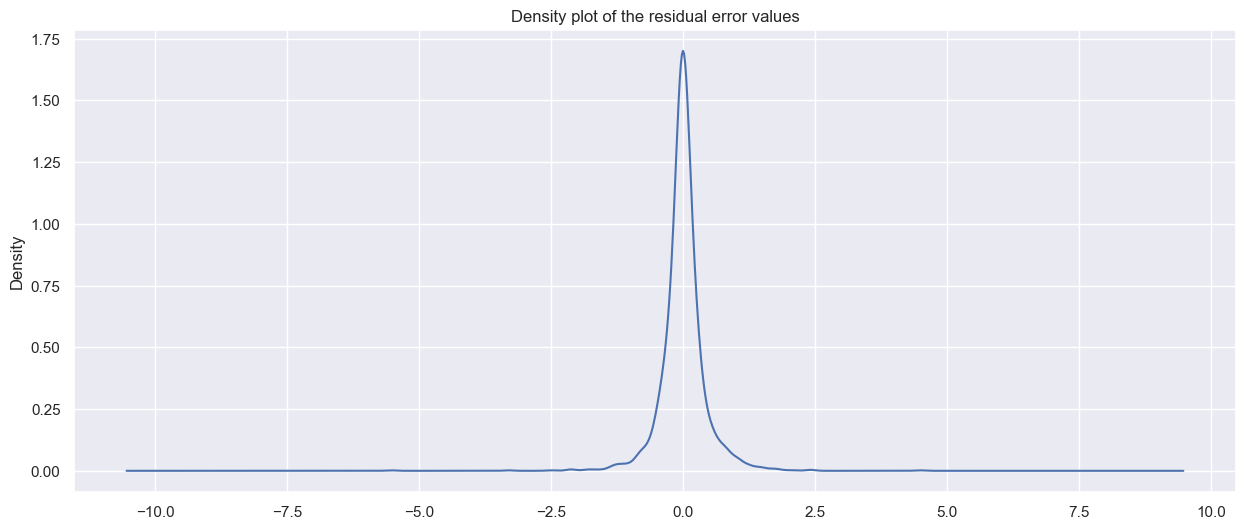

In [26]:
results_ARIMA.resid.plot(kind='kde')
plt.title('Density plot of the residual error values')
print(results_ARIMA.resid.describe())

In [27]:
# predictions_ARIMA_diff = np.sign(predictions_ARIMA_diff_log)*np.exp(predictions_ARIMA_diff_log)
print(len(predictions_ARIMA_diff))
len(ts)

2269


2270

In [28]:
(predictions_ARIMA_diff[::-1]*ts.shift(1)+ts.shift(1))[::-1]

<DTYYYYMMDD>
2019-03-22    10.536101
2019-03-21    23.047555
2019-03-20    26.362098
2019-03-19    40.370736
2019-03-18    41.577960
                ...    
2010-01-28    -2.748689
2010-01-27    -3.866269
2010-01-26    -5.071853
2010-01-25    24.980300
2010-01-22          NaN
Length: 2312, dtype: float64

In [ ]:
ts[::-1]

<DTYYYYMMDD>
2019-03-22    29.3000
2019-03-21    28.5000
2019-03-20    30.0000
2019-03-19    30.5000
2019-03-18    31.5000
2019-03-15    31.3000
2019-03-14    30.9000
2019-03-13    30.9000
2019-03-12    30.9000
2019-03-11    29.6000
2019-03-08    29.8500
2019-03-07    29.5000
2019-03-06    30.0000
2019-03-05    30.8500
2019-03-04    29.8000
2019-03-01    28.7500
2019-02-28    28.6500
2019-02-27    29.0000
2019-02-26    28.5000
2019-02-25    28.2000
2019-02-22    28.6000
2019-02-21    28.6500
2019-02-20    29.8000
2019-02-19    29.7000
2019-02-18    29.4000
2019-02-15    28.4000
2019-02-14    28.5000
2019-02-13    29.1000
2019-02-12    28.3500
2019-02-11    26.5000
               ...   
2010-03-11    17.8653
2010-03-10    18.2359
2010-03-09    18.3842
2010-03-08    18.3101
2010-03-05    18.2359
2010-03-04    18.5325
2010-03-03    18.5325
2010-03-02    18.5325
2010-03-01    18.2359
2010-02-26    18.1618
2010-02-25    18.9031
2010-02-24    19.7185
2010-02-23    19.2737
2010-02-22    19.19